In [1]:
import torch
from torchvision import datasets, models, transforms
from torch.nn import Linear

## 超参数

In [2]:
batch_size = 64
cloud_num = 28
focal_loss_gmma = 2.0
epochs = 150
model_name = 'resnet-50'
optimizer_name = 'radam'
scheduler_name = 'cosine_annealing_warm_restarts'
# scheduler_name = 'cosine_annealing'
# scheduler_name = 'none'
T_0 = 15
torch.manual_seed(42)

## 模型加载

使用`torchvision.models`中的resnet50作为预训练模型，并修改其全连接层。

In [3]:
def load_model(cloud_class_nums):
    pretrained_model = models.resnet50(weights=models.resnet.ResNet50_Weights.DEFAULT)
    num_ftrs = pretrained_model.fc.in_features
    pretrained_model.fc = Linear(num_ftrs, cloud_class_nums)
    return pretrained_model

model = load_model(cloud_num)

## 构建数据集类
根据`torch`官方文档修正`transform`参数:
- 训练阶段:将图片随机切分并`resize`到$224 \times 224$
- 验证阶段:
  - 将图片`resize`到$256 \times 256$
  - 截取`center`的$24 \times 224$

In [4]:
import os
from torch.utils.data import Dataset
from PIL import Image
from utils.autoaugment import ImageNetPolicy

class CloudImageDataSet(Dataset):
    def __init__(self, img_dir_path, img_set_with_label: dict, data_transforms=None, dataset = ''):
        self.imgs = list(img_set_with_label.keys())
        self.labels = list(img_set_with_label.values())
        self.data_transforms = data_transforms
        self.img_dir_path = img_dir_path
        self.dataset = dataset
        
    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, k):
        img_name = self.imgs[k]
        label = torch.nn.functional.one_hot(torch.tensor(self.labels[k] - 1), num_classes=cloud_num).double()
        img_path = os.path.join(self.img_dir_path, img_name)
        with open(img_path, 'rb') as img_file:
            img = Image.open(img_file)
            img = img.convert('RGB')
        img_file.close()
        return self.data_transforms[self.dataset](img), label

    
data_transforms = {
    'Train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        ImageNetPolicy(),
        # transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'Test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [6]:
import json
import pandas

train_dataset_df = pandas.read_csv('./cloud_dataset/train.csv').T
train_image_name_and_label_set = {}
for k, v in train_dataset_df.to_dict().items():
    train_image_name_and_label_set[v['FileName']] = v['Code']
val_dataset_df = pandas.read_csv('./cloud_dataset/standard_answer.csv').T
val_image_name_and_label_set = {}
for k, v in val_dataset_df.to_dict().items():
    val_image_name_and_label_set[v['FileName']] = v['Code']

In [7]:
model = model.to(device)

## Focal Loss

$-(1-p_t)log(p_t)$

In [8]:
from torch.nn import Softmax, CrossEntropyLoss

class FocalLoss(torch.nn.Module):
    def __init__(self, gmma):
        super().__init__()
        self.gmma = gmma
        self.softmax = Softmax(dim=1)
        self.cross_entropy_loss = CrossEntropyLoss()
    
    def forward(self, pred, label):
        pred_after_softmax = self.softmax(pred)
        ce = - torch.log(pred_after_softmax) * label
        focal_loss = (((1 - pred_after_softmax * label) ** self.gmma) * ce).sum() / batch_size
        return focal_loss

In [9]:
# loss_fn = torch.nn.CrossEntropyLoss()
loss_fn = FocalLoss(gmma=focal_loss_gmma)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = torch.optim.RAdam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=T_0, T_mult=1, verbose=True)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=T_0, verbose=True, eta_min=1e-4)
train_dataset = CloudImageDataSet('./cloud_dataset/images/', train_image_name_and_label_set, data_transforms, 'Train')
val_dataset = CloudImageDataSet('./cloud_dataset/images', val_image_name_and_label_set, data_transforms, 'Test')

Epoch 00000: adjusting learning rate of group 0 to 1.0000e-03.


## 训练
将`test.csv`中的数据加载，进行`K-Fold`训练

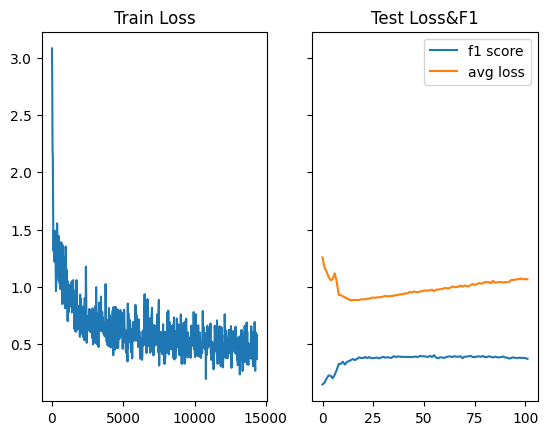

KeyboardInterrupt: 

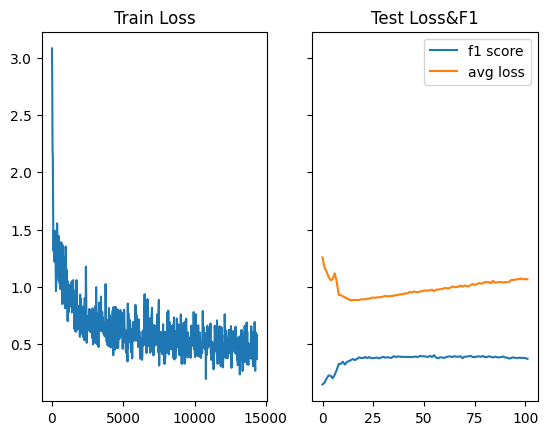

In [10]:
from torch.utils.data import DataLoader
from sklearn.metrics import f1_score
import time
import matplotlib.pyplot as plt
from IPython import display
import time

max_f1_score = 0
max_f1_score_model_name = ''
model_f1_set = []
model_avg_loss_set = []
iteration = 0
train_loss_set = []
timestamp = time.time()

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)


for epoch in range(epochs):
    
    train_set, val_set = train_dataset, val_dataset
    train_dataloader =  DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=8)
    val_dataloader = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=8)
    size = len(train_dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(train_dataloader):
        X = X.to(device)
        y = y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 20 == 0:
            iteration += 1
            loss, current = loss.item(), batch * batch_size
            train_loss_set.append(loss)
            ax1.clear()
            ax1.set_title('Train Loss')
            ax1.plot([20 * _ for _ in range(iteration)], train_loss_set, label="loss")
            display.clear_output(wait=True)
            display.display(f)
    test_loss, correct = 0, 0
    size = len(val_dataloader.dataset)
    num_batches = len(val_dataloader)
    if epoch < 14:
        scheduler.step()
    model.eval()
    with torch.no_grad():
        pred_set = torch.tensor([])
        y_set = torch.tensor([])
        for X, y in val_dataloader:
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            pred_set = torch.cat((pred_set, pred.cpu()), 0)
            y_set = torch.cat((y_set, y.cpu()), 0)
            correct += (pred.argmax(1) == y.argmax(1)).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    f1 = f1_score(pred_set.argmax(1), y_set.argmax(1), average=None).sum().item() / cloud_num
    if f1 > max_f1_score:
        max_f1_score = f1
        max_f1_score_model_name = f'./model_state_dict/model-{batch_size}-{focal_loss_gmma}-{model_name}-epoch{epoch}-optimizer{optimizer_name}-scheduler{scheduler_name}-f1-score{f1}'
    torch.save(model.state_dict(), f'./model_state_dict/model-{batch_size}-{focal_loss_gmma}-{model_name}-epoch{epoch}-optimizer{optimizer_name}-scheduler{scheduler_name}-f1-score{f1}')
    log_file = open(f'./log/log-{batch_size}-{focal_loss_gmma}-{model_name}-optimizer{optimizer_name}-scheduler{scheduler_name}-time{timestamp}.txt', 'a')
    print(f'epoch {epoch}---------------------------', file=log_file)
    model_f1_set.append(f1)
    model_avg_loss_set.append(test_loss)
    ax2.clear()
    ax2.plot(range(epoch + 1), model_f1_set, label="f1 score")
    ax2.plot(range(epoch + 1), model_avg_loss_set, label="avg loss")
    ax2.legend()
    ax2.set_title('Test Loss&F1')
    display.clear_output(wait=True)
    display.display(f)
    print(f"Val: \n Accuracy: {(100*correct):>0.1f}%, f1_score: {f1:>8f} Avg loss: {test_loss:>8f} \n", file=log_file)
    log_file.close()

In [10]:
test_dataset_df = pandas.read_csv('/home/codefor/cloud-form/cloud_dataset/test.csv').T
test_image_name_set = []
for k, v in test_dataset_df.to_dict().items():
    test_image_name_set.append(v['FileName'])

In [11]:
class CloudImageDataSetForTest(Dataset):
    def __init__(self, img_dir_path, img_set: list, data_transforms=None, dataset = ''):
        self.imgs = img_set
        self.data_transforms = data_transforms
        self.img_dir_path = img_dir_path
        self.dataset = dataset
        
    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, k):
        img_name = self.imgs[k]
        img_path = os.path.join(self.img_dir_path, img_name)
        with open(img_path, 'rb') as img_file:
            img = Image.open(img_file)
            img = img.convert('RGB')
        img_file.close()
        return self.data_transforms[self.dataset](img)

In [13]:
from torch.utils.data import DataLoader
test_dataset = CloudImageDataSetForTest('./cloud_dataset/images/', test_image_name_set, data_transforms, 'Test')
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=8)

In [14]:
model.load_state_dict(torch.load('./model_state_dict/model-64-2.0-resnet-50-epoch55-optimizerradam-schedulercosine_annealing_warm_restarts-f1-score0.40507934810646234'))
pred_set = torch.tensor([])
with torch.no_grad():
    model.eval()
    pred_set = torch.tensor([])
    for X in test_dataloader:
        X = X.to(device)
        pred = model(X)
        pred_set = torch.cat((pred_set, pred.cpu().argmax(1) + 1), 0)


In [19]:
submission = zip(test_image_name_set, pred_set.int().tolist())
submission = dict(submission)
submission = pandas.DataFrame([submission]).T
submission.to_csv('./cloud_dataset/submission.csv')

In [20]:
max_f1_score

0.40507934810646234

In [17]:
from sklearn.metrics import f1_score
y_set = torch.tensor(val_dataset.labels)
f1 = f1_score(pred_set, y_set, average=None).sum().item() / cloud_num

In [22]:
y_set = torch.tensor([])
pred_set = torch.tensor([])
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=8)
model.eval()
with torch.no_grad():
    pred_set = torch.tensor([])
    y_set = torch.tensor([])
    for X, y in val_dataloader:
        X = X.to(device)
        y = y.to(device)
        pred = model(X)
        pred_set = torch.cat((pred_set, pred.cpu()), 0)
        y_set = torch.cat((y_set, y.cpu()), 0)
f1 = f1_score(pred_set.argmax(1), y_set.argmax(1), average=None).sum().item() / cloud_num

In [25]:
y_set.argmax(1)

tensor([ 7,  7,  7,  ..., 12, 12, 12])

In [26]:
pred_set.argmax(1)

tensor([ 7,  7,  7,  ..., 12, 24,  1])